In [1]:
# imports
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/ML/Project")

Mounted at /content/drive


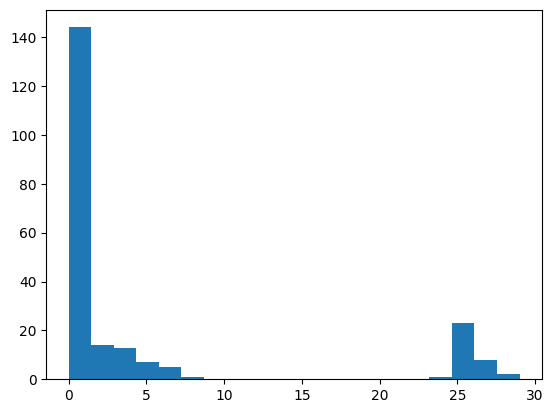

In [ ]:
import matplotlib.pyplot as plt

plt.hist(results, bins=20)

plt.show()
#rohkem kui 20 0-i siis peaks olema tegemist nendega, kes tegid eksami

In [23]:
import pandas as pd
import numpy as np

data = pd.read_csv ('data.csv')
log = pd.read_csv ('log.csv')
data_v = pd.read_csv('data-2021.csv')
log_v = pd.read_csv('log-2021.csv')

In [24]:
n=501
for i in range(len(data_v['Student'])):
    new="S"+str(n)
    old=data_v.iloc[i]['Student']
    data_v['Student'] = data_v['Student'].replace([old], new)
    log_v = log_v.replace(old,new)
    #print(df_2021.iloc[i]['Student'])
    n+=1

In [25]:
def log_mod(log,columns):
    day=8
    log=log.drop(log[(log['Activity'] == 'Week 1 quiz') & (log['Day'] > day)].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 quiz') & (log['Day'] == day) & (log['Time'] > '00:00')].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 homework') & (log['Day'] > day)].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 homework') & (log['Day'] == day) & (log['Time'] > '00:00')].index)
    day=11
    for i in range(2,17):
        homework = 'Week '+str(i)+' homework'
        quiz='Week '+str(i)+' quiz'
        day += 7
        if quiz in columns:
            log=log.drop(log[(log['Activity'] == quiz) & (log['Day'] > day)].index)
            log=log.drop(log[(log['Activity'] == quiz) & (log['Day'] == day) & (log['Time'] > '08:00')].index)
        if homework in columns:
            log=log.drop(log[(log['Activity'] == homework) & (log['Day'] > day)].index)
            log=log.drop(log[(log['Activity'] == homework) & (log['Day'] == day) & (log['Time'] > '08:00')].index)
    log.drop(log[log['Score'] == '-'].index, inplace=True)
    log = log.reset_index().groupby(['Student', 'Activity'])['Score'].aggregate('max').unstack()
    log.fillna(value=0, inplace=True)
    log = log.rename(columns={'Week 1 homework': 'Week 1 homework score', 'Week 1 quiz': 'Week 1 quiz score',
                        'Week 10 homework': 'Week 10 homework score', 'Week 10 quiz': 'Week 10 quiz score',
           'Week 11 homework': 'Week 11 homework score', 'Week 11 quiz': 'Week 11 quiz score',
                        'Week 12 quiz': 'Week 12 quiz score', 'Week 13 homework': 'Week 13 homework score',
           'Week 13 quiz': 'Week 13 quiz score', 'Week 14 homework': 'Week 14 homework score',
                        'Week 14 quiz': 'Week 14 quiz score', 'Week 15 homework': 'Week 15 homework score',
           'Week 15 quiz': 'Week 15 quiz score', 'Week 16 quiz': 'Week 16 quiz score', 'Week 2 homework': 'Week 2 homework score',
                        'Week 2 quiz': 'Week 2 quiz score', 'Week 3 homework': 'Week 3 homework score',
                        'Week 3 quiz': 'Week 3 quiz score', 'Week 4 homework': 'Week 4 homework score', 'Week 4 quiz': 'Week 4 quiz score',
           'Week 5 homework': 'Week 5 homework score', 'Week 5 quiz': 'Week 5 quiz score', 'Week 6 quiz': 'Week 6 quiz score',
                        'Week 7 homework': 'Week 7 homework score', 'Week 7 quiz': 'Week 7 quiz score', 'Week 8 homework': 'Week 8 homework score',
                        'Week 8 quiz': 'Week 8 quiz score', 'Week 9 homework': 'Week 9 homework score', 'Week 9 quiz': 'Week 9 quiz score'})
    log = log.reset_index()
    return log

In [26]:
def data_mod(data,log):
    data['sum_0'] = data[data == 0].count(axis=1)
    data = data.drop(data[(data['sum_0'] > 20) & (data['Grade'] == 'A')].index)
    data = data.drop(data[(data['Score'] == '-')].index)
    '''conditions = [
    (data['Score'].astype(float) > 65),
    (data['Score'].astype(float) > 55) & (data['Score'].astype(float) <= 65),
    (data['Score'].astype(float) > 35) & (data['Score'].astype(float) <= 55),
    (data['Score'].astype(float) <= 35)
    ]'''
    conditions = [
        (data['Score'].astype(float) > 65),
        (data['Score'].astype(float) > 35) & (data['Score'].astype(float) <= 65),
        (data['Score'].astype(float) <= 35)
    ]
    values = [1, 2, 3]
    data['Category'] = np.select(conditions, values)
    for student in data.Student:
        if student not in list(log.Student):
            data = data.drop(data[data.Student == student].index)
    return data

In [27]:
log=log_mod(log, log.columns)
log_v=log_mod(log_v, data_v.columns)
data=data_mod(data,log)
data_v= data_mod(data_v,log_v)
frames1 = [data, data_v]

data_comb = pd.concat(frames1)

frames2 = [log, log_v]

log_comb = pd.concat(frames2)

In [28]:
data_comb.loc[data_comb['Skill level']=='-']

,Student,Gender,Skill level,Week 1 quiz,Week 2 quiz,Week 3 quiz,Week 4 quiz,Week 5 quiz,Week 6 quiz,Week 7 quiz,...,Week 9 homework,Week 10 homework,Week 11 homework,Week 13 homework,Week 14 homework,Week 15 homework,Score,Grade,sum_0,Category
25,S026,F,-,6,3,1,1,1,1,1,...,1,1,1,0,0,1,68.9,D,2,1
55,S056,M,-,1,2,1,1,1,1,1,...,0,1,1,3,0,0,67.33,D,6,1
57,S058,M,-,0,1,1,1,1,4,1,...,4,4,0,6,0,0,89.26,B,6,1
66,S067,M,-,4,1,2,3,1,1,1,...,0,1,2,0,4,1,79.2,C,4,1
70,S071,M,-,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1.86,F,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,S815,M,-,1,3,1,3,2,3,1,...,13,7,3,9,2,13,76.03,C,0,1
317,S818,M,-,1,1,2,1,0,2,1,...,0,0,1,3,1,0,66.99,D,5,1
341,S842,M,-,2,3,4,7,3,3,1,...,5,2,1,11,2,15,100,A,0,1
351,S852,F,-,0,0,4,1,0,0,0,...,0,0,0,0,0,0,0.31,F,27,3


In [29]:
levels = data_comb['Skill level'].unique()
counts = []
for level in levels:
  counts.append(len(data_comb.loc[data_comb['Skill level']==level]))
print(counts, levels)

[121, 239, 30, 230, 85, 75] ['Novice' 'Proficient' 'Expert' 'Intermediate' 'Beginner' '-']


In [30]:
levels = data_comb['Skill level'].unique()
data_comb['Skill level'] = data_comb['Skill level'].replace('-', levels[0])
dummies = pd.get_dummies(data_comb['Skill level'])
data_comb = pd.concat([data_comb, dummies], axis='columns')
data_comb = data_comb.drop(['Skill level'], axis='columns')

In [31]:
print(len(log_comb))
print(len(data_comb))
for student in list(log_comb['Student']):
  if student not in list(data_comb['Student']):
    log_comb = log_comb.loc[log_comb['Student']!=student]
    log_comb = log_comb.reset_index(drop=True)
print(len(log_comb))

833
780
780


In [32]:
#all_comb = pd.concat([log_comb, data_comb], ignore_index=True)
all_comb = log_comb.merge(data_comb, on='Student')

In [33]:
all_comb

,Student,Week 1 homework score,Week 1 quiz score,Week 10 homework score,Week 10 quiz score,Week 11 homework score,Week 11 quiz score,Week 12 quiz score,Week 13 homework score,Week 13 quiz score,...,Week 15 homework,Score,Grade,sum_0,Category,Beginner,Expert,Intermediate,Novice,Proficient
0,S001,0.5,0.50,0.5,0.50,0.35,0.50,0.50,0.5,0.49,...,3,82.4,B,0,1,0,0,0,1,0
1,S002,0.5,0.50,0.5,0.45,0.5,0.50,0.44,0.5,0.50,...,6,93,A,0,1,0,0,0,0,1
2,S003,0.5,0.48,0.44,0.48,0.35,0.49,0.48,0.44,0.43,...,2,74.9,C,0,1,0,0,0,1,0
3,S004,0.5,0.50,0.5,0.50,0.5,0.48,0.39,0.5,0.48,...,1,98.9,A,0,1,0,0,0,0,1
4,S005,0.5,0.50,0.5,0.44,0.24,0.47,0.50,0.5,0.31,...,6,87.12,B,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,S878,0,0.48,0.33,0.42,0.5,0.50,0.50,0.28,0.47,...,7,80.05,B,0,1,0,0,0,1,0
776,S879,0.5,0.50,0.22,0.38,0.5,0.40,0.45,0.5,0.37,...,0,87.99,B,1,1,1,0,0,0,0
777,S880,0.5,0.00,0,0.15,0,0.14,0.30,0.44,0.18,...,1,74.63,C,3,1,0,0,0,1,0
778,S881,0.5,0.50,0.5,0.50,0.5,0.48,0.50,0.5,0.50,...,4,90.3,A,0,1,0,0,0,0,1


In [35]:
data = all_comb.drop(['Category', 'Student', 'Grade', 'Gender'], axis = 'columns')
target = all_comb[['Category']]

In [37]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
tl = TomekLinks()
train_X, test_X, train_y, test_y = train_test_split(data[['Week 1 homework', 'Week 1 quiz', 'Week 2 homework', 'Week 2 quiz',
                                                                      'Week 3 homework', 'Week 3 quiz', 'Week 4 homework', 'Week 4 quiz',
                                                              'Week 1 homework score', 'Week 1 quiz score', 'Week 2 homework score', 'Week 2 quiz score',
                                                                      'Week 3 homework score', 'Week 3 quiz score', 'Week 4 homework score', 'Week 4 quiz score',
                                                          'Week 5 homework', 'Week 5 quiz', 'Week 6 quiz', 'Week 5 homework score', 'Week 5 quiz score', 'Week 6 quiz score',
                                                              'Beginner', 'Expert', 'Intermediate', 'Novice', 'Proficient']], target, test_size=0.3)
'''X_under, y_under = tl.fit_resample(data[['Week 1 homework', 'Week 1 quiz', 'Week 2 homework', 'Week 2 quiz',
                                                                      'Week 3 homework', 'Week 3 quiz', 'Week 4 homework', 'Week 4 quiz',
                                                              'Week 1 homework score', 'Week 1 quiz score', 'Week 2 homework score', 'Week 2 quiz score',
                                                                      'Week 3 homework score', 'Week 3 quiz score', 'Week 4 homework score', 'Week 4 quiz score',
                                                              'Week 5 homework', 'Week 5 quiz', 'Week 6 quiz', 'Week 5 homework score', 'Week 5 quiz score', 'Week 6 quiz score',
                                                              'Beginner', 'Expert', 'Intermediate', 'Novice', 'Proficient']], target)

X_overunder, y_overunder = SMOTE().fit_resample(X_under, y_under)
train_X, test_X, train_y, test_y = train_test_split(X_overunder, y_overunder, test_size=0.3)'''

"X_under, y_under = tl.fit_resample(data[['Week 1 homework', 'Week 1 quiz', 'Week 2 homework', 'Week 2 quiz',\n                                                                      'Week 3 homework', 'Week 3 quiz', 'Week 4 homework', 'Week 4 quiz',\n                                                              'Week 1 homework score', 'Week 1 quiz score', 'Week 2 homework score', 'Week 2 quiz score',\n                                                                      'Week 3 homework score', 'Week 3 quiz score', 'Week 4 homework score', 'Week 4 quiz score',\n                                                              'Week 5 homework', 'Week 5 quiz', 'Week 6 quiz', 'Week 5 homework score', 'Week 5 quiz score', 'Week 6 quiz score',\n                                                              'Beginner', 'Expert', 'Intermediate', 'Novice', 'Proficient']], target)\n\nX_overunder, y_overunder = SMOTE().fit_resample(X_under, y_under)\ntrain_X, test_X, train_y, test_y = train_test_spl

array([[<Axes: title={'center': 'Category'}>]], dtype=object)

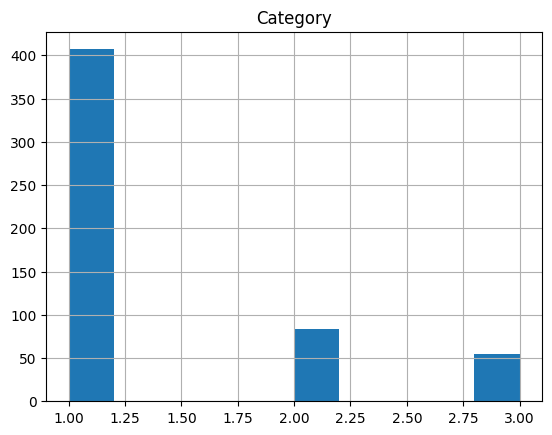

In [38]:
train_y.hist()

array([[<Axes: title={'center': 'Category'}>]], dtype=object)

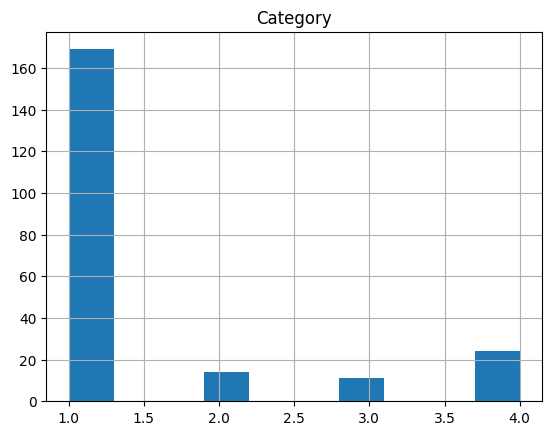

In [ ]:
test_y.hist()

In [39]:
#X_train, y_train = tl.fit_resample(train_X, train_y)
#X_test, y_test = tl.fit_resample(test_X, test_y)

train_X, train_y = SMOTE().fit_resample(train_X, train_y)
#test_X, test_y = SMOTE().fit_resample(X_test, y_test)

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
stacking_model = SVC()

'''('dtc', DecisionTreeClassifier(max_depth=2)),
              ('rf', RandomForestClassifier(max_depth=2, random_state=0)),
              ('lr', LogisticRegression()),'''
estimators = [('knn', KNeighborsClassifier(n_neighbors=3)),
              ('rf', RandomForestClassifier(max_depth=2, random_state=0)),
              ('gnb', GaussianNB())]
stack = StackingClassifier(estimators=estimators, final_estimator=stacking_model, cv=3)
stack.fit(train_X, train_y)

gnb = GaussianNB()
gnb.fit(train_X, train_y)

bagger = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=3, max_samples=0.8) #bootstrap=False
bagger.fit(train_X, train_y)

gbm = GradientBoostingClassifier(n_estimators=3, random_state=1)
np.random.seed(1111)
gbm.fit(train_X, train_y)

clf = RandomForestClassifier(max_depth=2, n_estimators=4, random_state=0)
clf.fit(train_X, train_y)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

KNeighborsClassifier(n_neighbors=3)

In [41]:
from sklearn.metrics import accuracy_score
predictions = clf.predict(test_X)
pred_knn = knn.predict(test_X)
pred_bag = bagger.predict(test_X)
pred_gbm = gbm.predict(test_X)
pred_stack = stack.predict(test_X)
pred_gnb = gnb.predict(test_X)
print(f'Random forest accuracy: {accuracy_score(test_y, predictions)}')
print(f'KNN accuracy: {accuracy_score(test_y, pred_knn)}')
print(f'Bagger accuracy: {accuracy_score(test_y, pred_bag)}')
print(f'GBM accuracy: {accuracy_score(test_y, pred_gbm)}')
print(f'Stacking Classifier accuracy: {accuracy_score(test_y, pred_stack)}')
print(f'Gaussian accuracy: {accuracy_score(test_y, pred_gnb)}')

Random forest accuracy: 0.688034188034188
KNN accuracy: 0.5897435897435898
Bagger accuracy: 0.7094017094017094
GBM accuracy: 0.6410256410256411
Stacking Classifier accuracy: 0.7264957264957265
Gaussian accuracy: 0.24358974358974358


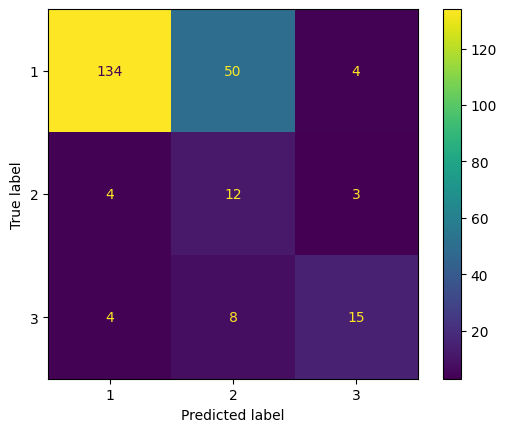

In [47]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(test_y.values, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])
cm_display.plot()
plt.show()

4
0.38461538461538464


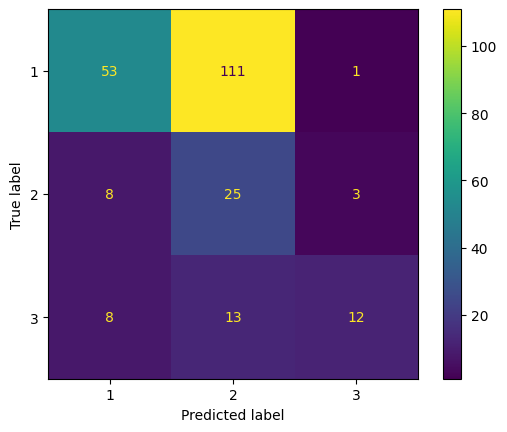

6
0.46153846153846156


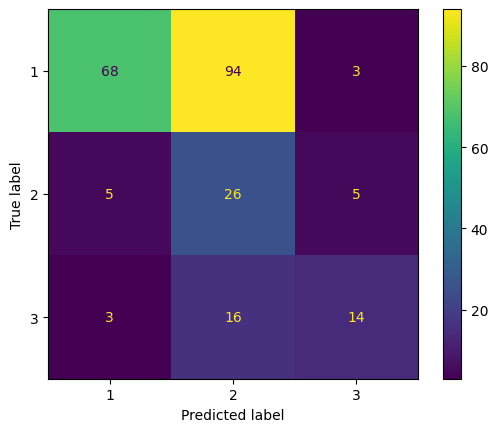

8
0.5299145299145299


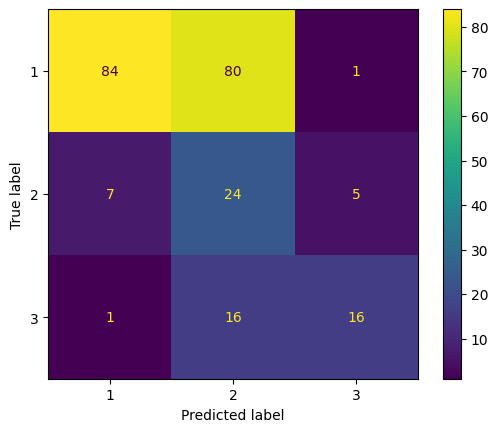

10
0.6623931623931624


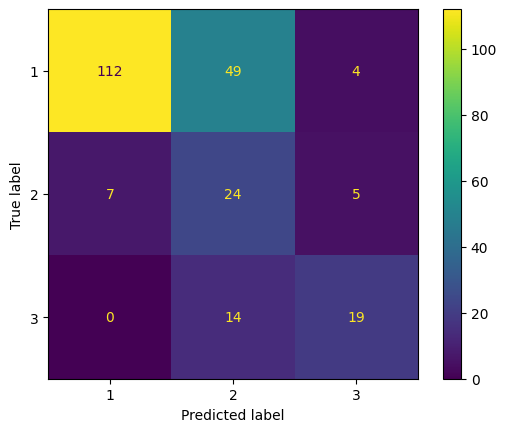

12
0.7051282051282052


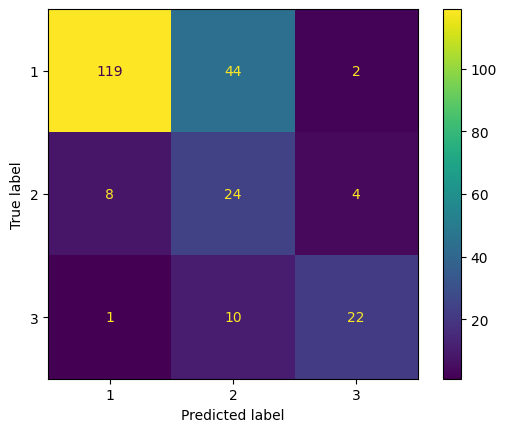

14
0.6965811965811965


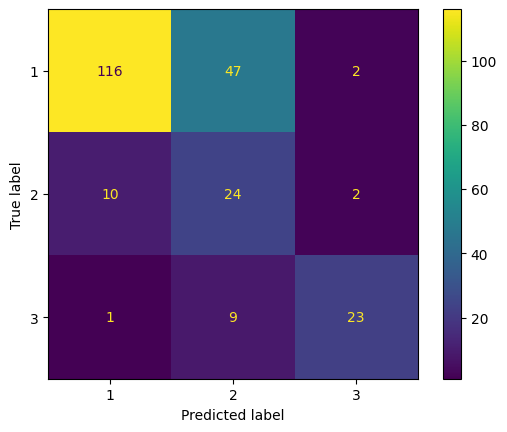

16
0.7435897435897436


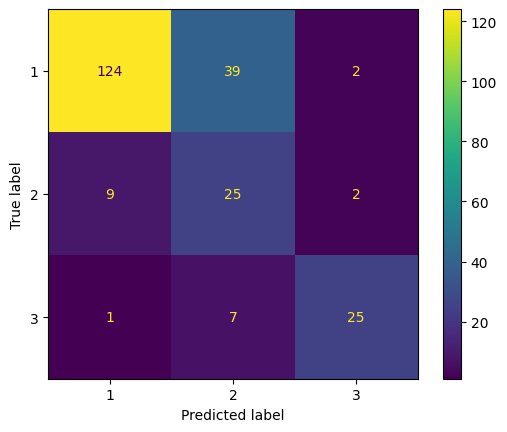

In [50]:
j=4
while j<=16:
    all_comb = log_comb.merge(data_comb, on='Student')
    all_comb = all_comb.drop('Gender', axis=1)
    all_comb = all_comb.drop('sum_0', axis=1)
    all_comb = all_comb.drop('Grade', axis=1)
    all_comb = all_comb.drop('Student', axis=1)
    all_comb = all_comb.drop('Score', axis=1)
    for i in range(j+1,17):
        homework = 'Week '+str(i)+' homework'
        quiz='Week '+str(i)+' quiz'
        h_score='Week '+str(i)+' homework score'
        q_score='Week '+str(i)+' quiz score'
        if homework in all_comb.columns:
            all_comb = all_comb.drop(homework, axis=1)
            all_comb = all_comb.drop(h_score, axis=1)
        if quiz in all_comb.columns:
            all_comb = all_comb.drop(quiz, axis=1)
            all_comb = all_comb.drop(q_score, axis=1)
    tl = TomekLinks()
    ros = SMOTE(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(all_comb.drop('Category', axis=1), all_comb.Category, test_size=0.3, random_state=42)
    X_resampled, y_resampled = tl.fit_resample(X_train, y_train)
    X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)
    gnb = GaussianNB()
    gnb.fit(X_resampled, y_resampled)
    pred=gnb.predict(X_test)
    print(j)
    print(accuracy_score(pred,y_test.values))
    confusion_matrix = metrics.confusion_matrix(y_test.values, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2,3])
    cm_display.plot()
    plt.show()
    j+=2